In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import os
import random
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.utils import shuffle

Folder : BHSig260-Bengali
B-S-1-F-01.tif


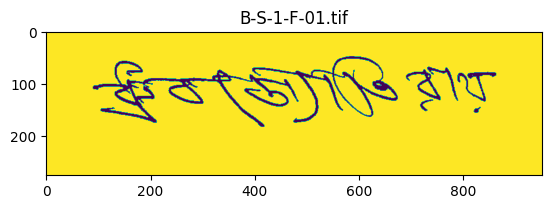

In [3]:
# Path to my dataset folder
dataset_path_1 = "datasets"

# Listing the subfolders inside this dataset folder
folders = os.listdir(dataset_path_1)

# Now let's convert that dataset path into folder paths, by concatenation with the folder name

for folder in folders:
    folder_path = os.path.join(dataset_path_1, folder)
    
    #List images inside each folder
    sub_folders = os.listdir(folder_path)
    
    for sub_folder in sub_folders:
        # Let's iterate through sub_images
        sub_folder_path = os.path.join(folder_path, sub_folder)

        images = os.listdir(sub_folder_path)
        
        print(f"Folder : {folder}")

        #Let's iterate through the images
        for image_name in images:
            print(image_name)
            image_path = os.path.join(sub_folder_path, image_name)

            #Let's load and display the images
            image = Image.open(image_path)
            plt.imshow(image)
            plt.title(image_name)
            plt.show()
            break  # Remove this line if you want to display all images in each subfolder
        break
    break


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Task-1
# Preprocessing steps - Gray scale, Gaussian blur, binarization, morphological closing, contour detection, filtering contours, filling contours and then bounding box drawing.
def preprocess_image(path, image_shape, name_gap_threshold=100):
    img_h, img_w = image_shape

    # Read the image in grayscale
    # The moment cv2.imread() is done, the image is now converted to a numpy array representation.
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #print(image)
    
    # Exception handeling for unreadable images.
    if image is None:
        raise ValueError(f"Image at path {path} could not be loaded.")
    
#     plt.imshow(image, cmap='gray')
#     plt.title('Original Image')
#     plt.show()

    # Gaussian blurring to remove noise
    blurred = cv2.GaussianBlur(image, (9, 9), 0)
#     plt.imshow(blurred, cmap='gray')
#     plt.title('Blurred Image')
#     plt.show()

    # Binarization using Otsu's thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     plt.imshow(binary, cmap='gray')
#     plt.title('Binary Image')
#     plt.show()

    # Morphological closing to fill gaps in the regions
    # Morphological closing is basically dialation followed by erosion, this helps fill in gaps, thus making outlines more prominent for further contour detection.
    kernel = np.ones((9, 9), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=10)
#     plt.imshow(closing, cmap='gray')
#     plt.title('After Morphological Closing')
#     plt.show()

    # Finding contours : Finds the outlines of teh signatures
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on position
    # I'm doing this so we can only filter larger gaps as contours for objects, that it won't consider tiny gaps between letters
    # as separate contours.
    filtered_contours = []
    for contour in contours:
        x, _, w, _ = cv2.boundingRect(contour)
        if w > name_gap_threshold:
            filtered_contours.append(contour)

    # Drawing filtered contours
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 255), 2)
#     plt.imshow(contour_image)
#     plt.title('Filtered Contours')
#     plt.show()

    # Drawing bounding rectangle
    if filtered_contours:
        x, y, w, h = cv2.boundingRect(cv2.convexHull(np.vstack(filtered_contours)))
        rect_image = image.copy()
        cv2.rectangle(rect_image, (x, y), (x + w, y + h), (0, 255, 255), 3)
#         plt.imshow(rect_image, cmap='gray')
#         plt.title('Bounding Rectangle')
#         plt.show()

        # Cropping the image
        cropped = image[y:y + h, x:x + w]
#         plt.imshow(cropped, cmap='gray')
#         plt.title('Cropped Image')
#         plt.show()

        # Resizing the cropped image
        resized = cv2.resize(cropped, (img_w, img_h), interpolation=cv2.INTER_LANCZOS4)
#         plt.imshow(resized, cmap='gray')
#         plt.title('Resized Image')
#         plt.show()

        # Binarization of resized image
        _, resized_binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         plt.imshow(resized_binary, cmap='gray')
#         plt.title('Resized Binary Image')
#         plt.show()
    else:
        print("No valid contours found.")
        return None

    return resized_binary


In [5]:
# Function to load the BHSig260 dataset and create triplets
def load_dataset(data_dir, num_genuine, num_forged, image_size):
    triplets = []

    try:
        # Iterate through each folder (person)
        for person_folder in os.listdir(data_dir):
            person_path = os.path.join(data_dir, person_folder)

            genuine_signatures = []
            forged_signatures = []

            # Load genuine and forged signatures for the person
            for filename in os.listdir(person_path):

                if '-G-' in filename:
                    genuine_signatures.append(preprocess_image(os.path.join(person_path, filename), image_size))
                elif '-F-' in filename:
                    forged_signatures.append(preprocess_image(os.path.join(person_path, filename), image_size))

            # Randomly select num_genuine genuine signatures and num_forged forged signatures
            # Adding this step to make sure we are selecting from an equally balanced dataset, to avoid imbalance.
            selected_genuine = random.sample(genuine_signatures, min(num_genuine, len(genuine_signatures)))
            selected_forged = random.sample(forged_signatures, min(num_forged, len(forged_signatures)))

            # Create triplets
            # 30 seemed to give the most efficient accuracy , and we had more data.
            for i in range(30):
                anchor = random.choice(selected_genuine)
                positive = random.choice(selected_genuine)
                negative = random.choice(selected_forged)
                triplets.append([anchor, positive, negative])    
    except KeyboardInterrupt:
        print("Keyboard interrupt received. Returning triplets created so far.")
        return np.array(triplets)
#     print(triplets[0])
    return np.array(triplets)

In [6]:
# I wrote a separate method for CEDAR datasets because they had different naming conventions, however the same load_datasets() function
# could have been used with an and condition. I just choose this for better readability.
def load_cedar_dataset(data_dir, num_genuine, num_forged, image_size):
    triplets = []
    
    try:
    # Iterate through each folder (person)
        for person_folder in os.listdir(data_dir):
            person_path = os.path.join(data_dir, person_folder)

            genuine_signatures = []
            forged_signatures = []

            # Load genuine and forged signatures for the person
            for filename in os.listdir(person_path):

                if 'original' in filename:
                    genuine_signatures.append(preprocess_image(os.path.join(person_path, filename), image_size))
                elif 'forgeries' in filename:
                    forged_signatures.append(preprocess_image(os.path.join(person_path, filename), image_size))

            # Randomly select num_genuine genuine signatures and num_forged forged signatures
            selected_genuine = random.sample(genuine_signatures, min(num_genuine, len(genuine_signatures)))
            selected_forged = random.sample(forged_signatures, min(num_forged, len(forged_signatures)))

            # Create triplets
            for i in range(30):
                anchor = random.choice(selected_genuine)
                positive = random.choice(selected_genuine)
                negative = random.choice(selected_forged)
                triplets.append([anchor, positive, negative])

    except KeyboardInterrupt:
        print("Keyboard interrupt received. Returning triplets created so far.")
        return np.array(triplets)
        
#     print(triplets)
    return np.array(triplets)

In [7]:
# I am choosing a Siamese network with triplet loss, so I can create an embedding matrix toverify
# if two images are closer(genuine) or farther apart(one genuine, one forged) using Euclidean distance.

# For this I am employing the triplet loss function as a measure to minimize distance between positive signatures(genuine), and
# Maximise distance between negative signatures(one positive and one forged signature).

# Here I am defining the triplet loss function
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + alpha, 0.0)
    return tf.reduce_mean(loss)

In [8]:
# I am defining the CNN for teh Siamese architecture
# Here I am creating a CNN where I will take 3 inputs - anchor,positive,negative
# I will apply the triplet loss function such that I can create an embedding that has genuine signatures close by and
# Forged images far away in teh embdedding space.

def build_triplet_network(input_shape=(150, 400, 1)):
    
    # Defining the input shape (dimensions of the i/p image)
    input_layer = Input(shape=input_shape, name='input')

    # I will sequentially apply Conv layers followed by maxpool layers so that I can extract the feature map.
    def conv_block(x, filters, kernel_size, pool_size, name):
        x = Conv2D(filters, kernel_size, activation='relu', padding='same', name=f'{name}_conv')(x)
        x = MaxPooling2D(pool_size, name=f'{name}_pool')(x)
        return x

    # Create blocks of these feature maps
    x = conv_block(input_layer, 32, (3, 3), (2, 2), 'block1')
    x = conv_block(x, 64, (3, 3), (2, 2), 'block2')
    x = conv_block(x, 128, (3, 3), (2, 2), 'block3')
    x = conv_block(x, 256, (3, 3), (2, 2), 'block4')

    # Now I will flatten the conv layers into a 1D vector
    # Dense layers are fully connected layers to further process the extracted features.
    # I'll do drop out regularization, to make my model more robust with missing neurons during training.
    # I'll use a normalization layer using Ridge regression (L2), which will help learn embeddings.
    # Personal Note : Normalizing the output vectors ensures that they lie on a hypersphere with a fixed radius, making the embedding 
    # space more uniform and easier to learn meaningful representations.
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    # x = Dense(144, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    # x = Dropout(0.8, name='dropout2')(x)
    x = Dense(128, activation='relu', name='fc3')(x)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l2_norm')(x)

    # Our base Siamese n/w by defining what i/p layer and o/p layers are.
    base_network = Model(input_layer, x, name='base_network')

    # These are our triplet inputs
    input_anchor = Input(shape=input_shape, name='anchor')
    input_positive = Input(shape=input_shape, name='positive')
    input_negative = Input(shape=input_shape, name='negative')

    # I am utilizing the base model from earlier to compute embeddings for our anchor, positive, negative i/p(s).
    encoded_anchor = base_network(input_anchor)
    encoded_positive = base_network(input_positive)
    encoded_negative = base_network(input_negative)

    # I am concatenating my embeddings of anchor,positive and negative into a single vector
    # Basically we need one vector space ultimately that can denote distances for all the datapoints.
    merged_vector = Lambda(lambda x: tf.stack(x, axis=1), name='stacked_embeddings')([encoded_anchor, encoded_positive, encoded_negative])
    model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_vector, name='triplet_model')
    model.compile(loss=triplet_loss, optimizer=Adam(learning_rate=1e-4))

    # I will return the compiled Siamese n/w model.
    return model

In [9]:
# Load the BHSig260 dataset and create triplets
data_dir_B = 'datasets/BHSig260-Bengali'
X_sign1 = load_dataset(data_dir_B, num_genuine=24, num_forged=24, image_size=(150,400))

In [10]:
X_sign1

array([[[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]],


       [[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 

In [11]:
# Load the BHSig260 dataset and create triplets
data_dir_H = 'datasets/BHSig260-Hindi'
X_sign3 = load_dataset(data_dir_H, num_genuine=24, num_forged=24, image_size=(150,400))

In [12]:
X_sign3

array([[[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]],


       [[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 

In [13]:
# Load the CEDAR dataset and create triplets
data_dir_C = 'datasets/CEDAR'
X_sign2 = load_cedar_dataset(data_dir_C, num_genuine=24, num_forged=24, image_size=(150,400))

In [14]:
X_sign2

array([[[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],

        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]],


       [[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 

In [15]:
# Okay, now from earlier - I had created different triplet datasets from Bengali,CEDAR and Hindi datasets
# Now I will concatenate all those into one dataset, so as to later use it to split into train,val,test

X_sign_combined = np.concatenate((X_sign1, X_sign2, X_sign3), axis=0)
# Shuffle the combined dataset to induce randomness and robustness for the model's training
X_sign = shuffle(X_sign_combined)

In [16]:
# Task-2
# Now we shall split the data into train,val and test sets
X_train_val_sign, X_test_sign = train_test_split(X_sign, test_size=0.2, random_state=42)
X_train_sign, X_val_sign = train_test_split(X_train_val_sign, test_size=0.2, random_state=42)

In [17]:
# Define the triplet network model
triplet_model = build_triplet_network(input_shape=(150, 400, 1))

In [18]:
# Then train the model
history = triplet_model.fit(
    [X_train_sign[:, 0], X_train_sign[:, 1], X_train_sign[:, 2]],
    np.zeros((X_train_sign.shape[0], 1)),  # Dummy labels for training
    epochs=33, 
    batch_size=16, 
    validation_data=(
        [X_val_sign[:, 0], X_val_sign[:, 1], X_val_sign[:, 2]], 
        np.zeros((X_val_sign.shape[0], 1))  # Dummy labels for validation
    )
)

Epoch 1/33
58/58 [==============================] - 22s 243ms/step - loss: 0.2184 - val_loss: 0.1999
Epoch 2/33
58/58 [==============================] - 10s 171ms/step - loss: 0.2133 - val_loss: 0.1999
Epoch 3/33
58/58 [==============================] - 10s 171ms/step - loss: 0.2100 - val_loss: 0.2000
Epoch 4/33
58/58 [==============================] - 10s 172ms/step - loss: 0.2134 - val_loss: 0.2000
Epoch 5/33
58/58 [==============================] - 10s 173ms/step - loss: 0.2148 - val_loss: 0.2000
Epoch 6/33
58/58 [==============================] - 10s 172ms/step - loss: 0.2107 - val_loss: 0.1999
Epoch 7/33
58/58 [==============================] - 10s 173ms/step - loss: 0.2083 - val_loss: 0.1998
Epoch 8/33
58/58 [==============================] - 10s 172ms/step - loss: 0.2044 - val_loss: 0.1997
Epoch 9/33
58/58 [==============================] - 10s 173ms/step - loss: 0.2020 - val_loss: 0.1994
Epoch 10/33
58/58 [==============================] - 10s 173ms/step - loss: 0.2079 - val_lo

In [28]:
# Let's note these vals for refernce later
loss = 0.0033
val_loss = 0.0244

In [19]:
# Evaluate the model on the test dataset
test_loss = triplet_model.evaluate(
    [X_test_sign[:, 0], X_test_sign[:, 1], X_test_sign[:, 2]],
    np.zeros((X_test_sign.shape[0], 1))  # Dummy labels for testing
)

9/9 [==============================] - 3s 91ms/step - loss: 0.0216


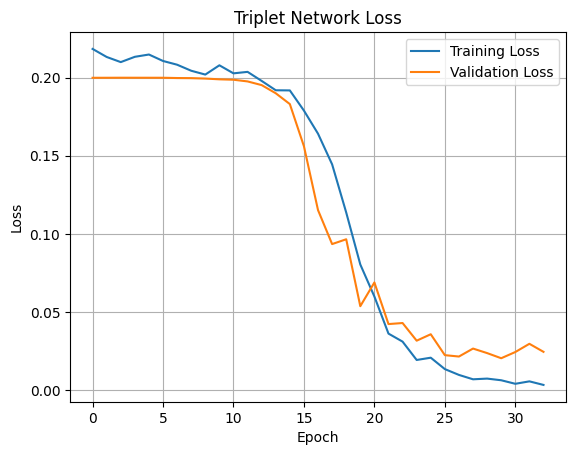

In [20]:
import matplotlib.pyplot as plt
# Assuming 'history' object is available after training the model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_loss))  # Get the number of epochs

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Triplet Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [21]:
def generate_embeddings(model, data):
    embeddings = model.predict([data[:, 0], data[:, 1], data[:, 2]])
    return embeddings

In [22]:
def compute_distances(embeddings):
    anchor_embeddings = embeddings[:, 0]
    positive_embeddings = embeddings[:, 1]
    negative_embeddings = embeddings[:, 2]
    
    # Compute distances
    positive_distances = np.linalg.norm(anchor_embeddings - positive_embeddings, axis=1)
    negative_distances = np.linalg.norm(anchor_embeddings - negative_embeddings, axis=1)
    
    return positive_distances, negative_distances

In [23]:
# Define function to predict labels based on distances of anchor-positive and anchor-negative pairs
def predict_labels_with_thresholds(positive_distances, negative_distances, threshold):
    predicted_labels_positive = np.zeros(len(positive_distances), dtype=int)
    predicted_labels_negative = np.zeros(len(negative_distances), dtype=int)
    predicted_labels_positive[positive_distances < threshold] = 1  
    predicted_labels_negative[negative_distances > threshold] = 1  
    return predicted_labels_positive, predicted_labels_negative

# Set the threshold based on the validation loss at epoch 22
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]  # Adjust this threshold based on your validation loss

# Generate embeddings for the whole dataset
embeddings = generate_embeddings(triplet_model, X_sign)

# Compute distances for each triplet
positive_distances, negative_distances = compute_distances(embeddings)

accuracy=[]

for i in threshold:
# Determine predicted labels using the threshold
    predicted_labels_positive, predicted_labels_negative = predict_labels_with_thresholds(positive_distances, negative_distances, i)
    count_pos = sum(1 for elem in predicted_labels_positive if elem == 1)
    count_neg = sum(1 for elem in predicted_labels_negative if elem == 1)

# Calculate accuracy
    acc = (count_pos + count_neg) / (len(predicted_labels_positive) + len(predicted_labels_negative))
    accuracy.append(acc)
    
print(accuracy[-1])

45/45 [==============================] - 4s 89ms/step
0.5


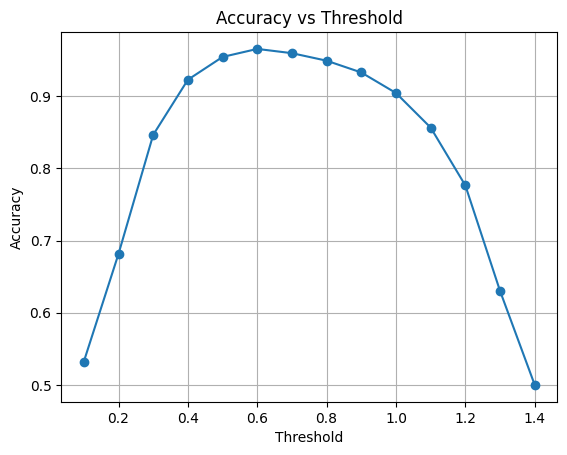

In [24]:
import matplotlib.pyplot as plt
plt.plot(threshold, accuracy, marker='o')
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

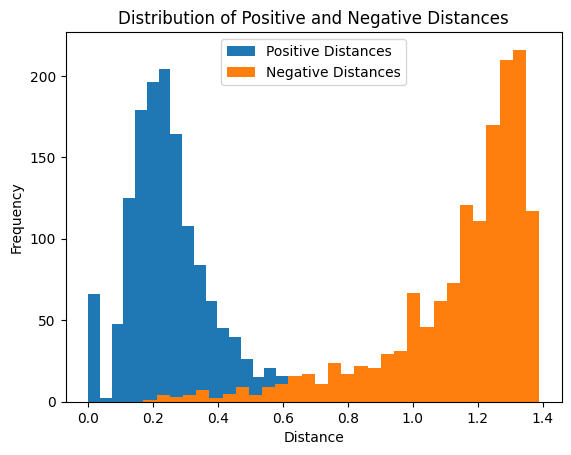

In [25]:
import matplotlib.pyplot as plt


plt.hist(positive_distances, bins=30, label='Positive Distances')
plt.hist(negative_distances, bins=30, label='Negative Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Positive and Negative Distances')
plt.legend()
plt.show()

In [29]:
# Task-3
# Let's check how accurate this model is on predictions (Note accuracy is low due to hardware constraints)
def calculate_metrics(predicted_labels_positive, predicted_labels_negative):
    total_positives = len(predicted_labels_positive)
    total_negatives = len(predicted_labels_negative)

    # Assuming 1 represents a correct prediction
    correct_positives = np.sum(predicted_labels_positive)
    correct_negatives = np.sum(predicted_labels_negative)

    total_correct = correct_positives + correct_negatives
    accuracy = total_correct / (total_positives + total_negatives)

    precision = correct_positives / (correct_positives + total_negatives - correct_negatives)
    recall = correct_positives / (correct_positives + total_positives - correct_positives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

# Example usage:
predicted_labels_positive = np.array([1, 0, 1, 1, 0])  # Example positive predictions
predicted_labels_negative = np.array([0, 1, 0, 0, 1])  # Example negative predictions

accuracy, precision, recall, f1_score = calculate_metrics(predicted_labels_positive, predicted_labels_negative)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Loss:", loss)
print("Val Loss:", val_loss)

Accuracy: 0.5
Precision: 0.5
Recall: 0.6
F1 Score: 0.5454545454545454
Loss: 0.0033
Val Loss: 0.0244


In [ ]:
# !!!NOTE!!!
# I'd like to mention that teh scores are a bit low, because I have done this on my local GPU
# My system is an Nvidia GeForce GTX 1650 , that has 4GB RAM for the GPU.
# Thus to avoid CUDA GPU memory issue which was happening, I had to use a subset of the data
# So my fine tuning values are actually as per my laptop's capability
# This model however with more GPU can be run to get higher accuracies.
# I've done my best in the case of implementations and explanations and detailed documentation of what
# coding I've done.